In [86]:
# all imports here

import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')


### Picking the Highest Volatility Stock

In [43]:
df = pd.read_csv("../data/SP20-2017-2021-1.csv", index_col=0, parse_dates=True)

returns = df.pct_change()
vol = returns.std().sort_values(ascending=False)
print(vol.head(10))

highest_vol_stock = vol.index[0]
data = df[[highest_vol_stock]].copy()
data.rename(columns={highest_vol_stock: "price"}, inplace=True)

print(data.head())

MRO     0.036576
AMD     0.035314
FCX     0.032355
MU      0.028857
NFLX    0.024224
INCY    0.023691
CHK     0.022324
WMB     0.022264
VRTX    0.022224
SO      0.015730
dtype: float64
                price
Date                 
2017-01-03  16.718727
2017-01-04  16.991726
2017-01-05  17.114101
2017-01-06  16.831692
2017-01-09  16.379837


### Caculating the MACD and RSI 

In [ ]:
ema12 = data["price"].ewm(span=12, adjust=False).mean()
ema26 = data["price"].ewm(span=26, adjust=False).mean()

data["MACD"] = ema12 - ema26
data["Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()
data["Histogram"] = data["MACD"] - data["Signal"]


delta = data["price"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain, index=data.index).rolling(14).mean()
roll_down = pd.Series(loss, index=data.index).rolling(14).mean()

RS = roll_up / roll_down
data["RSI"] = 100 - (100 / (1 + RS))


data["trend"] = np.where(data["MACD"] > data["Signal"], 1, -1)
data["signal"] = 0   # 1 = buy, -1 = sell, 0 = no trade

for i in range(1, len(data)):
    rsi_prev = data["RSI"].iloc[i-1]
    rsi_now = data["RSI"].iloc[i]
    trend_now = data["trend"].iloc[i]

    # BUY: bullish trend & RSI crosses up from below 30 to above 30
    if trend_now == 1 and rsi_prev < 30 and rsi_now >= 30:
        data.loc[data.index[i], "signal"] = 1

    # SELL: bearish trend & RSI crosses down from above 70 to below 70
    if trend_now == -1 and rsi_prev > 70 and rsi_now <= 70:
        data.loc[data.index[i], "signal"] = -1



position = []
holding = 0

for i in range(len(data)):
    sig = data["signal"].iloc[i]

    if sig == 1:
        holding = 1
    elif sig == -1:
        holding = 0

    position.append(holding)

data["position"] = position

print("Buys:", (data["signal"] == 1).sum())
print("Sells:", (data["signal"] == -1).sum())

print(data.tail())



Buys: 5
Sells: 5
                price      MACD    Signal  Histogram        RSI  trend  \
Date                                                                     
2021-11-01  17.030001  0.807285  0.900778  -0.093493  66.016708     -1   
2021-11-02  16.920000  0.791681  0.878958  -0.087278  65.650956     -1   
2021-11-03  16.490000  0.736131  0.850393  -0.114262  54.742547     -1   
2021-11-04  16.570000  0.690602  0.818435  -0.127833  55.227869     -1   
2021-11-05  17.115000  0.690537  0.792855  -0.102318  58.509303     -1   

            signal  position  
Date                          
2021-11-01       0         0  
2021-11-02       0         0  
2021-11-03       0         0  
2021-11-04       0         0  
2021-11-05       0         0  


### Plots 

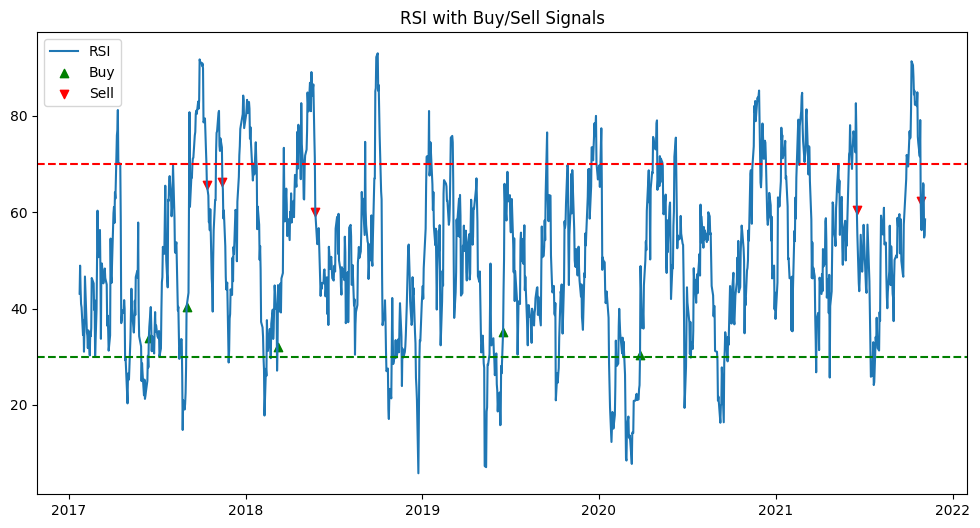

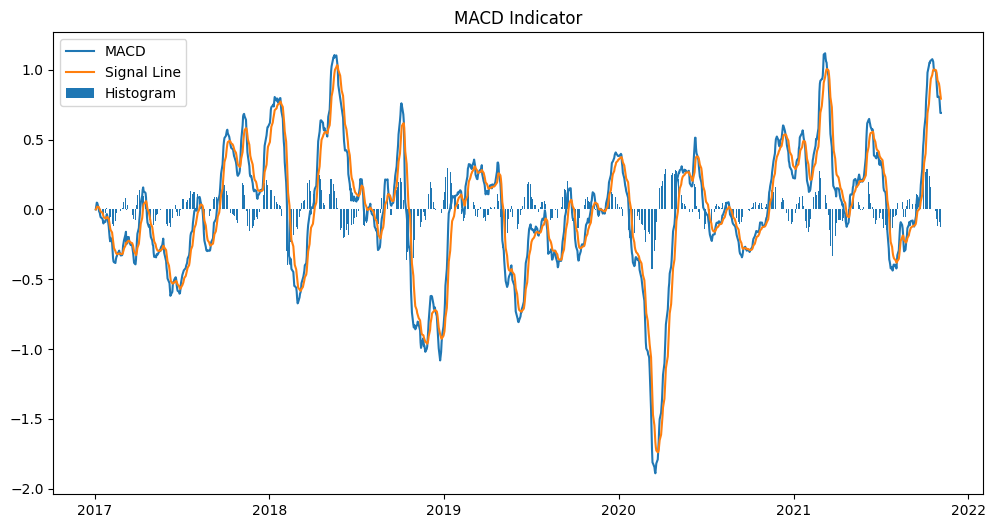

In [65]:
# Plot RSI and buy/sell markers
plt.figure(figsize=(12,6))
plt.plot(data.index, data["RSI"], label="RSI")
plt.axhline(30, color="green", linestyle="--")
plt.axhline(70, color="red", linestyle="--")

# buy signals (green)
buy_idx = data[data["signal"] == 1].index
plt.scatter(buy_idx, data.loc[buy_idx, "RSI"], color="green", label="Buy", marker="^")

# sell signals (red)
sell_idx = data[data["signal"] == -1].index
plt.scatter(sell_idx, data.loc[sell_idx, "RSI"], color="red", label="Sell", marker="v")

plt.title("RSI with Buy/Sell Signals")
plt.legend()
plt.show()

# Plot MACD trend
plt.figure(figsize=(12,6))
plt.plot(data.index, data["MACD"], label="MACD")
plt.plot(data.index, data["Signal"], label="Signal Line")
plt.bar(data.index, data["Histogram"], label="Histogram")

plt.title("MACD Indicator")
plt.legend()
plt.show()

### Single Plot 

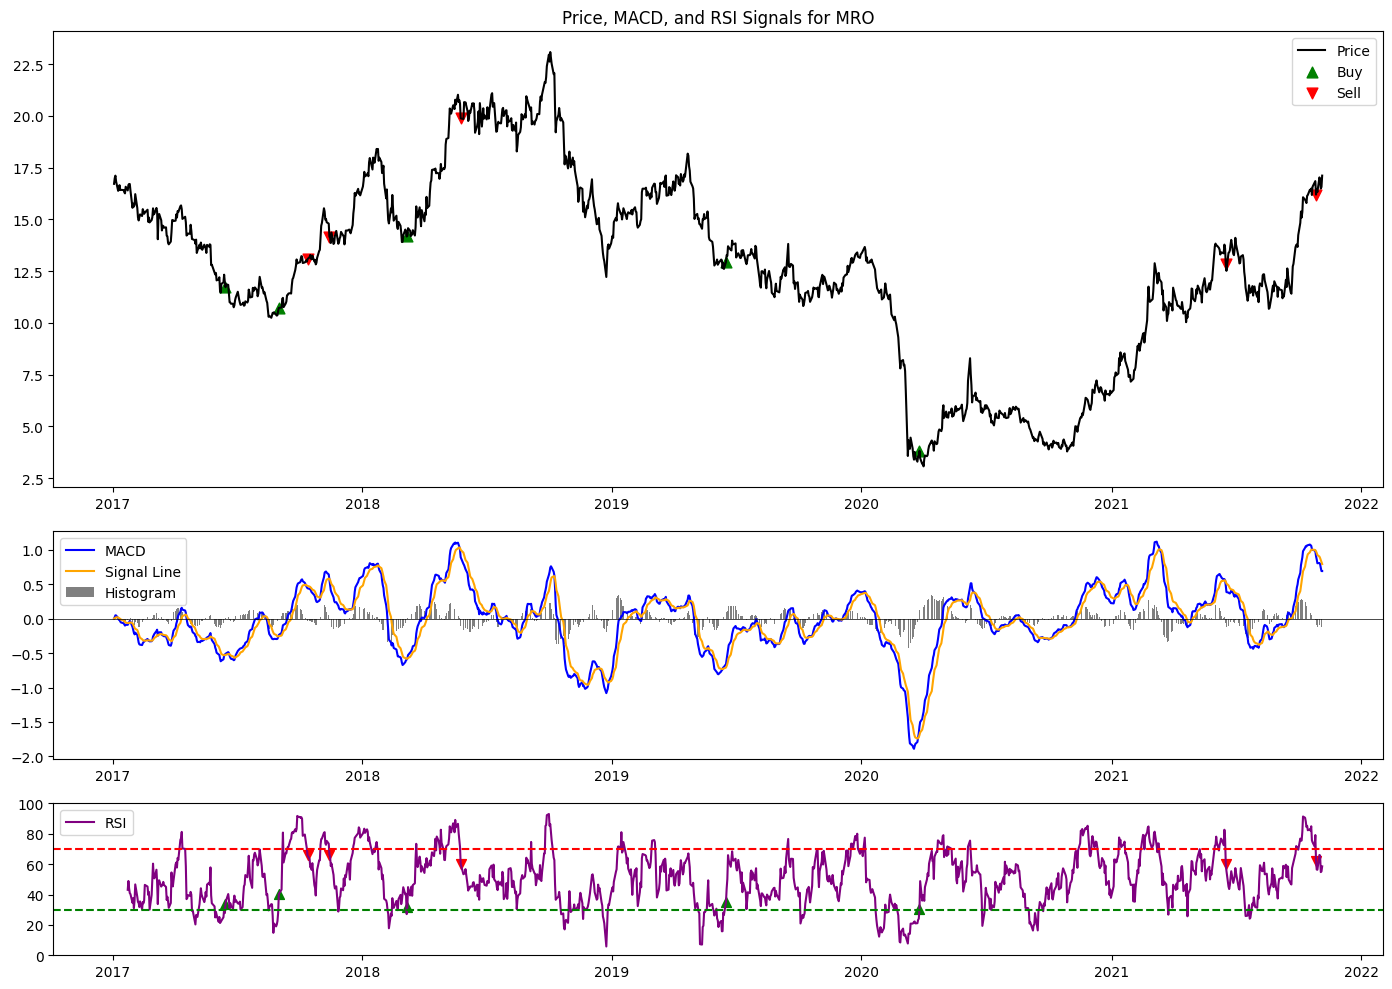

In [66]:


fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1.5, 1])


# PRICE CHART

ax1 = plt.subplot(gs[0])
ax1.plot(data.index, data["price"], label="Price", color="black")

# mark buy/sell on price chart
ax1.scatter(buy_idx, data.loc[buy_idx, "price"], color="green", marker="^", s=60, label="Buy")
ax1.scatter(sell_idx, data.loc[sell_idx, "price"], color="red", marker="v", s=60, label="Sell")

ax1.set_title(f"Price, MACD, and RSI Signals for {highest_vol_stock}")
ax1.legend()


# MACD PANEL

ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(data.index, data["MACD"], label="MACD", color="blue")
ax2.plot(data.index, data["Signal"], label="Signal Line", color="orange")
ax2.bar(data.index, data["Histogram"], label="Histogram", color="gray")

ax2.axhline(0, color='black', linewidth=0.5)
ax2.legend()


# RSI PANEL

ax3 = plt.subplot(gs[2], sharex=ax1)
ax3.plot(data.index, data["RSI"], label="RSI", color="purple")
ax3.axhline(30, color="green", linestyle="--")
ax3.axhline(70, color="red", linestyle="--")

# buy/sell markers on RSI
ax3.scatter(buy_idx, data.loc[buy_idx, "RSI"], color="green", marker="^", s=50)
ax3.scatter(sell_idx, data.loc[sell_idx, "RSI"], color="red", marker="v", s=50)

ax3.set_ylim(0, 100)
ax3.legend()

plt.tight_layout()
plt.show()


## ML based Trading Strategy

In [75]:
df = pd.read_csv("../data/all_stocks_10_2015_2020.csv", index_col=0, parse_dates=True)

# health check
print(df.info())

print("NaN count:")
display(df.isna().sum())

print("\nZero count:")
display((df == 0).sum())

print("\nNegative count:")
display((df < 0).sum())

print("\nInfinite count:")
display(np.isinf(df).sum())

print("\nDuplicate dates:")
print(df.index.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1490 entries, 2015-01-02 to 2020-12-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   1490 non-null   float64
 1   TSLA    1490 non-null   float64
 2   FB      1490 non-null   float64
 3   AMZN    1490 non-null   float64
 4   AAPL    1490 non-null   float64
 5   MSFT    1490 non-null   float64
 6   VOD     1490 non-null   float64
 7   ADBE    1490 non-null   float64
 8   NVDA    1490 non-null   float64
 9   CRM     1490 non-null   float64
dtypes: float64(10)
memory usage: 128.0 KB
None
NaN count:


GOOGL    0
TSLA     0
FB       0
AMZN     0
AAPL     0
MSFT     0
VOD      0
ADBE     0
NVDA     0
CRM      0
dtype: int64


Zero count:


GOOGL    0
TSLA     0
FB       0
AMZN     0
AAPL     0
MSFT     0
VOD      0
ADBE     0
NVDA     0
CRM      0
dtype: int64


Negative count:


GOOGL    0
TSLA     0
FB       0
AMZN     0
AAPL     0
MSFT     0
VOD      0
ADBE     0
NVDA     0
CRM      0
dtype: int64


Infinite count:


GOOGL    0
TSLA     0
FB       0
AMZN     0
AAPL     0
MSFT     0
VOD      0
ADBE     0
NVDA     0
CRM      0
dtype: int64


Duplicate dates:
0


### Feature Set Preparation

In [106]:
features = {}

for stock in df.columns:
    temp = pd.DataFrame()
    temp["price"] = df[stock]          # clean numeric price
    temp["EMA14"] = ta.ema(temp["price"], length=14)
    temp["EMA22"] = ta.ema(temp["price"], length=22)
    temp["RSI"]   = ta.rsi(temp["price"], length=14)
    temp["PPO"]   = ta.ppo(temp["price"]).PPO_12_26_9
    temp["MACD"]  = ta.macd(temp["price"]).MACD_12_26_9
    temp["CMO"]   = ta.cmo(temp["price"], length=14)
    
    # Log return
    temp["RETURN"] = np.log(temp["price"] / temp["price"].shift(1))
    
    # Target variable: trend tomorrow (1 = up, 0 = down)
    temp["TARGET"] = (temp["price"].shift(-1) > temp["price"]).astype(int)
    
    # Drop first 30 rows (indicator warmup)
    temp = temp.dropna().copy()
    
    features[stock] = temp


#see how our features table looks for AAPL 
display(features["AAPL"])



,price,EMA14,EMA22,RSI,PPO,MACD,CMO,RETURN,TARGET
Date,,,,,,,,,
2015-02-09,27.204641,26.384667,25.796532,49.439650,3.792269,1.018780,-1.120699,0.006621,1
2015-02-10,27.727283,26.563682,25.964423,53.791702,4.028740,1.039385,7.583404,0.019029,1
2015-02-11,28.377174,26.805481,26.174227,58.567499,4.254870,1.095526,17.134998,0.023168,1
2015-02-12,28.736204,27.062911,26.397008,60.967581,4.825775,1.155668,21.935162,0.012573,1
2015-02-13,28.877092,27.304802,26.612668,61.900268,5.018941,1.200856,23.800535,0.004891,1
...,...,...,...,...,...,...,...,...,...
2020-11-24,114.464355,116.137458,115.936853,47.215391,1.557253,0.338315,-5.569217,0.011528,1
2020-11-25,115.319077,116.028340,115.883133,49.044440,1.579461,0.246214,-1.911120,0.007439,1
2020-11-27,115.875641,116.007980,115.882482,50.253251,1.626697,0.215648,0.506502,0.004815,1


### Strategy 1 

In [107]:
results = {}

for stock , df_features in features.items():


    train = df_features.loc["2015": "2018"].copy()
    test = df_features.loc["2020"].copy()
    X_train = train[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_train = train["TARGET"]
    X_test  = test[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_test  = test["TARGET"]

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Predictions for 2020
    preds = rf.predict(X_test)
    test  = test.copy()
    test['preds'] = preds
    test["position"] = test["preds"]
    test["strategy_return"] = test["RETURN"] * test["position"]

    mean_returns = test["strategy_return"].mean()
    std_returns = test["strategy_return"].std()
    sharpe_returns = mean_returns / std_returns if std_returns !=0 else 0
    results[stock] = sharpe_returns

    print(f"{stock}: Sharpe = {sharpe_returns:.4f}")

GOOGL: Sharpe = -0.1136
TSLA: Sharpe = -0.1320
FB: Sharpe = -0.1346
AMZN: Sharpe = 0.0072
AAPL: Sharpe = -0.2015
MSFT: Sharpe = -0.1047
VOD: Sharpe = -0.0621
ADBE: Sharpe = -0.1381
NVDA: Sharpe = -0.1526
CRM: Sharpe = -0.2456


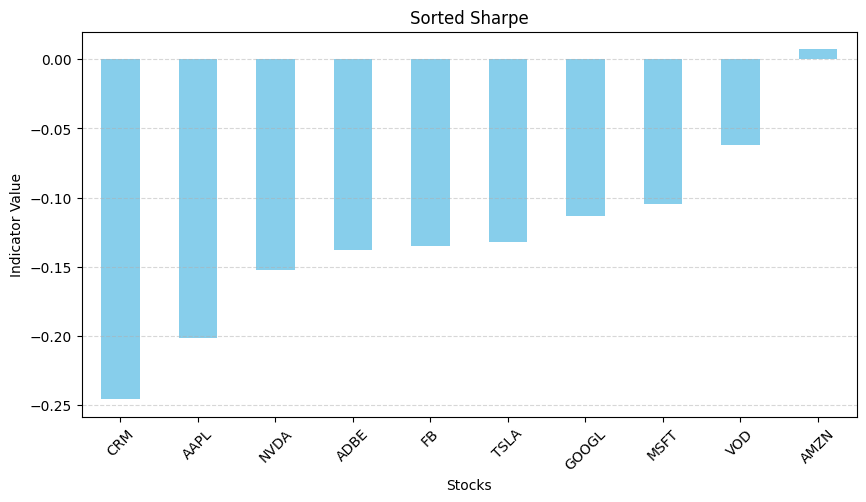

In [108]:
results_series = pd.Series(results).sort_values()

results_series.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Sorted Sharpe")
plt.ylabel("Indicator Value")
plt.xlabel("Stocks")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

 The best performance for strategy 1 is Amazon , though its barely positive

### Strategy 2 

In [ ]:
#using the previous feature set, we just need to change the strategy for target variable 

delta = 0.1
for stock in features:

    df_temp = features[stock]

    df_temp["pct_change"] = df_temp["price"].pct_change()
    df_temp["target2"] = (df_temp["pct_change"] >= delta).astype(int)
    df_temp2 = df_temp.drop(columns=["TARGET"])

    features[stock] = df_temp2.dropna().copy()

display(features["AAPL"].head())


,price,EMA14,EMA22,RSI,PPO,MACD,CMO,RETURN,pct_change,target2
Date,,,,,,,,,,
2015-02-10,27.727283,26.563682,25.964423,53.791702,4.028740,1.039385,7.583404,0.019029,0.019212,0
2015-02-11,28.377174,26.805481,26.174227,58.567499,4.254870,1.095526,17.134998,0.023168,0.023439,0
2015-02-12,28.736204,27.062911,26.397008,60.967581,4.825775,1.155668,21.935162,0.012573,0.012652,0
2015-02-13,28.877092,27.304802,26.612668,61.900268,5.018941,1.200856,23.800535,0.004891,0.004903,0
2015-02-17,29.047516,27.537164,26.824393,63.050430,5.123996,1.236170,26.100860,0.005884,0.005902,0


In [110]:
results_strategy2 = {}

for stock , df_features in features.items():


    train = df_features.loc["2015": "2018"].copy()
    test = df_features.loc["2020"].copy()
    X_train = train[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_train = train["target2"]
    X_test  = test[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_test  = test["target2"]

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Predictions for 2020
    preds = rf.predict(X_test)
    test  = test.copy()
    test['preds'] = preds
    test["position"] = test["preds"]
    test["strategy_return"] = test["RETURN"] * test["position"]

    mean_returns = test["strategy_return"].mean()
    std_returns = test["strategy_return"].std()
    sharpe_returns = mean_returns / std_returns if std_returns !=0 else 0
    results_strategy2[stock] = sharpe_returns

    print(f"{stock}: Sharpe = {sharpe_returns:.4f}")

GOOGL: Sharpe = 0.0000
TSLA: Sharpe = 0.2189
FB: Sharpe = 0.0000
AMZN: Sharpe = 0.0000
AAPL: Sharpe = 0.0000
MSFT: Sharpe = 0.0000
VOD: Sharpe = 0.0000
ADBE: Sharpe = 0.0000
NVDA: Sharpe = 0.0000
CRM: Sharpe = 0.0857


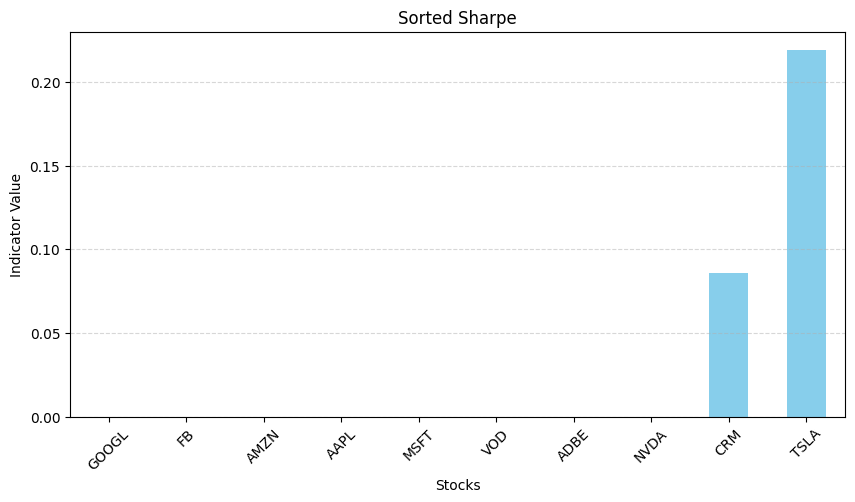

In [111]:
results_series = pd.Series(results_strategy2).sort_values()

results_series.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Sorted Sharpe")
plt.ylabel("Indicator Value")
plt.xlabel("Stocks")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

* From strategy 1 we got amazon as best sharpe based on p[i] > p[i-1] strategy 
* From strategy 2 we got tesla as best sharpe by checking pct_change() > 0.1

---
we can choose amazon and check for different values of deltas

In [116]:
delta_list = [0.02, 0.05, 0.06 , 0.07 ,0.08 ,  0.09 , 0.10 , 0.12, 0.15]

best_stock = "AMZN"  
df = features[best_stock].copy()
results_delta = {}

for delta in delta_list:

    df2 = df.copy()
    df2["pct_change"] = df2["price"].pct_change()

    # new target rule
    df2["TARGET_delta"] = (df2["pct_change"] >= delta).astype(int)

    df2 = df2.dropna().copy()

    # train-test split
    train = df2.loc["2015":"2018"]
    test  = df2.loc["2020"]

    X_train = train[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_train = train["TARGET_delta"]

    X_test = test[["EMA14","EMA22","RSI","PPO","MACD","CMO","RETURN"]]
    y_test = test["TARGET_delta"]

    # model
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)

    test = test.copy()
    test["pred"] = preds
    test["position"] = test["pred"]
    test["strategy_return"] = test["RETURN"] * test["position"]

    mean_r = test["strategy_return"].mean()
    std_r  = test["strategy_return"].std()
    sharpe = mean_r/std_r if std_r != 0 else 0

    results_delta[delta] = sharpe
    print(f"δ = {delta}: Sharpe = {sharpe:.4f}")



δ = 0.02: Sharpe = 0.4496
δ = 0.05: Sharpe = 0.1874
δ = 0.06: Sharpe = 0.1750
δ = 0.07: Sharpe = 0.0929
δ = 0.08: Sharpe = 0.0000
δ = 0.09: Sharpe = 0.0000
δ = 0.1: Sharpe = 0.0000
δ = 0.12: Sharpe = 0.0000
δ = 0.15: Sharpe = 0.0000


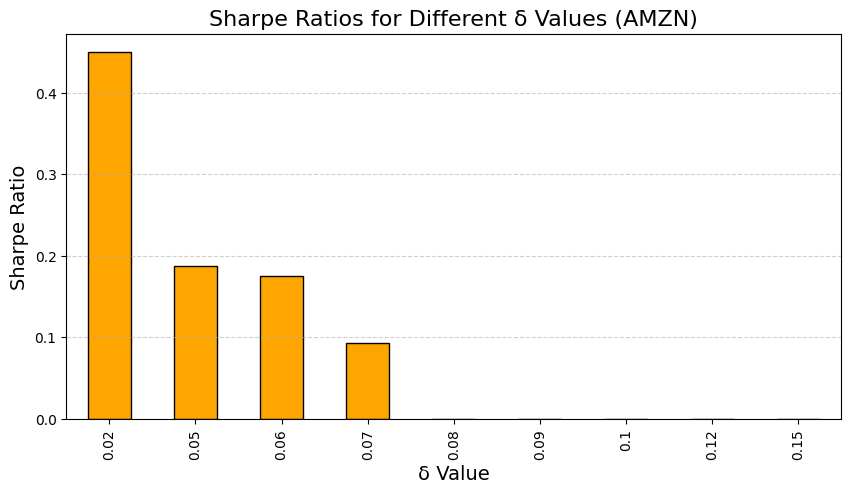

In [117]:
df_delta = pd.DataFrame.from_dict(results_delta, orient="index", columns=["Sharpe"])
df_delta_sorted = df_delta.sort_values("Sharpe", ascending=False)

plt.figure(figsize=(10,5))
df_delta_sorted["Sharpe"].plot(kind="bar", color="orange", edgecolor="black")

plt.title("Sharpe Ratios for Different δ Values (AMZN)", fontsize=16)
plt.ylabel("Sharpe Ratio", fontsize=14)
plt.xlabel("δ Value", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


As we can see, the highest sharpe happens when $ \delta = 0.02 $ as 0.4496 and after 7% daily change we see that sharpe is 0 , since the pct_change() would not be execeeding more than 7% to generate any trading signal



## **Conclusion**

* This assignment illustrates how technical indicators and machine-learning models can be combined to design systematic trading strategies. 

* In **Part 1**, using MACD to detect trend direction and RSI to identify reversal points demonstrates how momentum indicators can be layered to improve signal quality and avoid false entries. 

* In **Part 2**, we used a Random Forest classifier trained on engineered technical features to predict short-term price direction and evaluate a simple rule-based trading system across multiple stocks. 

* By comparing Sharpe ratios, we identified the best-performing asset and then refined the trading rule by adjusting the return threshold ( $\delta$ ). 

* This project highlights how quantitative traders iteratively test, validate, and tune strategy parameters using out-of-sample performance rather than relying on intuition alone. 

* In real markets, this workflow—feature construction, model training, rule design, and parameter evaluation—forms the foundation of data-driven trading and is essential for building strategies that are robust across changing market conditions.




##  Institutional Perspective

While this project utilizes technical indicators (MACD, RSI), it is important to note how professional quantitative firms view these tools:

* Limitations of Indicators: Institutional firms rarely rely on raw indicators like MACD or RSI because they are lagging, highly correlated, and offer limited predictive power in isolation.
* Professional Approach: Hedge funds prioritize statistically validated factors, market microstructure signals, and complex machine-learning pipelines over simple rule-based heuristics.
* Rigorous Validation: When technical indicators are used, they serve as minor features within larger models and undergo extensive stability and regime testing.

* The Value of This Project: Despite the simplicity of the indicators used, this assignment replicates the **core quantitative workflow**: defining features, training models, performing out-of-sample validation, and evaluating performance via the Sharpe ratio.
